<h3> R snippet: </h3>

- remove duplicates based on lat,long,species,year 
- add seasons info

Use R kernel to run

In [ ]:
library(tidyverse)

total = read.csv("GBif_Original.csv", stringsAsFactors = FALSE, sep="\t")

unq_rows = as.numeric(rownames(unique(total[c("species","year","decimalLatitude","decimalLongitude")])))
total_unq = total[unq_rows,]

total$coor = paste0(total$decimalLatitude, total$decimalLongitude)
total_unq$coor = paste0(total_unq$decimalLatitude, total_unq$decimalLongitude)
month_count = total %>% group_by(species, year, coor) %>% summarise(paste(unique(month), collapse = ", "))
colnames(month_count)[ncol(month_count)] = "months"

total_unq = total_unq[order(total_unq$species, total_unq$year, total_unq$coor),]
month_count = month_count[order(month_count$species, month_count$year, month_count$coor),]
#total_unq$months = month_count$`paste(unique(month), collapse = ", ")`
#sep_months = sapply(total_unq$months, strsplit, ", ")
sep_months = month_count$months

total_unq$Winter = 0
total_unq$Spring = 0
total_unq$Summer = 0
total_unq$Fall = 0
for (row in 1:nrow(total_unq)) {
  if (any(c(1,2,12) %in% sep_months[row][[1]][1])) {total_unq$Winter[row] = 1}
  if (any(c(3:5) %in% sep_months[row][[1]][1])) {total_unq$Spring[row] = 1}
  if (any(c(6:8) %in% sep_months[row][[1]][1])) {total_unq$Summer[row] = 1}
  if (any(c(9:11) %in% sep_months[row][[1]][1])) {total_unq$Fall[row] = 1}
  #if (row %% 15000 == 0) {print(paste("Loop is ", round(row/nrow(total_unq)*100), "% done", sep = ""))}
}

total_unq$coor = NULL

write.csv(total_unq, "GBif_R.csv")


<h3> Python snippets: </h3>

- convert dataset keys to dataset names
- add redList designation
- add common names from ITIS
- drop unnecessary columns
- add geometry from lat, long
- convert data to species per year in geojson

Use Python2 kernel to run

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
# from geojson import GeometryCollection

import requests
import json
import pickle
import numpy as np
from python_helpers import column_helpers as ch
import sqlite3
import os

In [7]:
df = pd.read_csv("gbif_summary_pre with municipalities.csv", low_memory=False)
df = ch.dataSetNamesFromKey(df, read_pickle="datasetKeyNames.pickle")

In [9]:
df.to_csv("gbif_summary.csv", encoding="latin1")

In [ ]:
df = pd.read_csv("GBif_R.csv", low_memory=False)
df = applyTransformations(df)

In [2]:
def yearSpeciesCount(df):
    df = df.dropna(subset = ['year'])
    df.year = df['year'].astype(int)
    gp_series = df.groupby(['year']).size()
    year_counts = list(zip(gp_series.index, gp_series))

def some(df, n):
    return df.loc[random.sample(df.index, n)]
    
def testingFilter(df):
    df = df[(df['year'] == 2017) | (df['year'] == 2016) | (df['year'] == 2015)]
    df = df[(df["species"] == "Corvus caurinus") | (df["species"] == "Turdus migratorius") |
           (df["species"] == "Larus glaucescens")]
    return df

def applyTransformations(df):
    df = ch.dataSetNamesFromKey(df, read_pickle="datasetKeyNames.pickle")
    df = ch.addCommonNames(df, "ITIS.sqlite")
    df = ch.addRedList(df, "redlist_assessments.csv")
    return df

def pointCSVtoJSONPerYear(df):
    df = df[['species', 'Winter', 'Spring', 'Summer', 'Fall', 'datasetName', 'common', 
                     'redList', 'decimalLatitude', 'decimalLongitude', 'year']]
    geo_df = ch.toGEOdf(df)    
    geo_df = geo_df.drop(['decimalLatitude', 'decimalLongitude'], 1)
    gb = geo_df.groupby(['year'])
    for k, gp in gb:
#        gp.drop(['year'], 1)
       gp.to_file("leaflet/gbif/" + str(int(k)) + ".geojson", driver="GeoJSON")
    return geo_df

def pointCSVtoJSONPerYearPerSpecies(df):
    df = df[['species', 'Winter', 'Spring', 'Summer', 'Fall', 'datasetName', 'common', 
                     'redList', 'decimalLatitude', 'decimalLongitude', 'year']]
    geo_df = ch.toGEOdf(df)
    geo_df = geo_df.drop(['decimalLatitude', 'decimalLongitude'], 1)
    #split into species per year as gejsons            
    gb_year = geo_df.groupby(['year'])
    for k_year, gp_year in gb_year:
        gp_year = gp_year.drop(['year'], 1)
        gp_species = gp_year.groupby(['species'])
        os.mkdir('leaflet/gbif_year_species/' + str(int(k_year)))
        for k_species, gp_species in gp_species:
            gp_species.to_file("map_django/biodivmap/static/biodivmap/gbif_year_species" + str(int(k_year))
                               + '/'+ k_species + ".geojson", driver="GeoJSON")
        print(str(int(k_year)) + " done!")
    return geo_df



In [3]:
BASE_PATH = 'map_django/biodivmap/static/biodivmap/'
taxonLevels = ['gbif','kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
file_count = 0

def pointCSVtoJSONPerYearPerTaxonLimited(df, lim=1000):
    df = df.dropna(axis=0, subset=['species'])
    geo_df = ch.toGEOdf(df)
    geo_df = geo_df.drop(['decimalLatitude', 'decimalLongitude'], 1)
    #split into species per year as gejsons            
    gb_year = geo_df.groupby(['year'])
    os.mkdir(BASE_PATH + 'gbif/')
    master_count = 0
    dbCon = sqlite3.connect("map_django/db.sqlite3")
    cur   = dbCon.cursor()
    for k_year, gp_year in gb_year:
        gp_year = gp_year.drop(['year'], 1)
        year_path = BASE_PATH + 'gbif/' + str(int(k_year)) + "/"
        os.mkdir(year_path)
        master_count += perTaxonWriterYear(0, gp_year, year_path, lim, cur, str(int(k_year)))
        print(str(int(k_year)) + " done!")
    dbCon.commit()
    dbCon.close()
    return geo_df, master_count

def perTaxonWriterYear(taxonIndex, df, path, lim, cur, year):
    if (taxonLevels[taxonIndex] == "species" or df.shape[0] <= lim):
        for spec in list(df.species.unique()):
            cur.execute("UPDATE species_year SET (%s) = ?  WHERE species = ?" %("year_"+ year),(path.replace(BASE_PATH,""), spec,))
        df.to_file(path + "points"+ ".geojson", driver="GeoJSON")
        return 1
    else:
        gb_nextTaxonLevel = df.groupby([taxonLevels[taxonIndex+1]])
        inner_count = 0
        for k_nextTaxon, gp_nextTaxon in gb_nextTaxonLevel:
            next_path = path + k_nextTaxon + "/"
            os.mkdir(next_path)
            inner_count+=perTaxonWriterYear(taxonIndex+1, gp_nextTaxon, next_path, lim, cur,year)
        return inner_count
    

In [4]:
BASE_PATH = 'map_django/biodivmap/static/biodivmap/'
taxonLevels = ['gbif', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
file_count = 0

def pointCSVtoJSONPerRecencyPerTaxonLimited(df, lim=1000):
    df = df.dropna(axis=0, subset=['species'])
    geo_df = ch.toGEOdf(df)
    geo_df = geo_df.drop(['decimalLatitude', 'decimalLongitude'], 1)
    # split into species per recency as gejsons
    gb_rec = geo_df.groupby(['recency'])
    os.mkdir(BASE_PATH + 'gbif/')
    master_count = 0
    dbCon = sqlite3.connect("map_django/db.sqlite3")
    cur = dbCon.cursor()
    for k_rec, gp_rec in gb_rec:
        # gp_rec = gp_rec.drop(['recency'], 1)
        rec_path = BASE_PATH + 'gbif/' + k_rec + "/"
        os.mkdir(rec_path)
        master_count += perTaxonWriterRecency(0, gp_rec, rec_path, lim, cur, k_rec)
        print(k_rec + " done!")
    dbCon.commit()
    dbCon.close()
    return geo_df, master_count


def perTaxonWriterRecency(taxonIndex, df, path, lim, cur, rec):
    if (taxonLevels[taxonIndex] == "species" or df.shape[0] <= lim):
        for spec in list(df.species.unique()):
            cur.execute("UPDATE biodivmap_speciesrecency SET (%s) = ?  WHERE species = ?" % (rec),
                        (path.replace(BASE_PATH, ""), spec,))
        df.to_file(path + "points" + ".geojson", driver="GeoJSON")
        return 1
    else:
        gb_nextTaxonLevel = df.groupby([taxonLevels[taxonIndex + 1]])
        inner_count = 0
        for k_nextTaxon, gp_nextTaxon in gb_nextTaxonLevel:
            next_path = path + k_nextTaxon + "/"
            os.mkdir(next_path)
            inner_count += perTaxonWriterRecency(taxonIndex + 1, gp_nextTaxon, next_path, lim, cur, rec)
        return inner_count

In [13]:
df =pd.read_csv("GBif June27.csv")

In [14]:
df = df.drop(['Unnamed: 0', 'Winter', 'Spring', 'Summer', 'Fall'], 1)

In [16]:
pointCSVtoJSONPerRecencyPerTaxonLimited(df)

/Users/raghav/anaconda2/envs/jupy2/lib/python2.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


both done!
old done!
recent done!


(                                              datasetName  \
 0                 iNaturalist Research-grade Observations   
 1       University of British Columbia Herbarium (UBC)...   
 2       University of British Columbia Herbarium (UBC)...   
 3       University of British Columbia Herbarium (UBC)...   
 4       University of British Columbia Herbarium (UBC)...   
 5       University of British Columbia Herbarium (UBC)...   
 6       University of British Columbia Botanical Garde...   
 7       University of British Columbia Botanical Garde...   
 8       University of British Columbia Herbarium (UBC)...   
 9       University of British Columbia Herbarium (UBC)...   
 10      University of British Columbia Herbarium (UBC)...   
 11                iNaturalist Research-grade Observations   
 12      University of British Columbia Herbarium (UBC)...   
 13      University of British Columbia Herbarium (UBC)...   
 14                  Geographically tagged INSDC sequences   
 15     

In [ ]:
def makeYearsColsDB(years, db_path):
    col_query = """CREATE TABLE species_year (
    species TEXT NOT NULL PRIMARY KEY,"""
    for year in years:
        if (year == 2019):
            col_query+="""year_""" + str(year) + """ INTEGER DEFAULT 0"""
        else:
            col_query+="""year_""" + str(year) + """ INTEGER DEFAULT 0,"""
    col_query += """);""" 
    
    dbCon = sqlite3.connect(db_path)
    cur   = dbCon.cursor()
    cur.execute(col_query)
    dbCon.commit()
    dbCon.close()


def fillSpeciesIntoDB(df, db_path):
    dbCon = sqlite3.connect(db_path)
    cur   = dbCon.cursor()
    for spec in list(df.species.unique()):
        cur.execute("INSERT INTO biodivmap_speciesrecency (species) VALUES (?)",(spec,))
    dbCon.commit()
    dbCon.close()

In [ ]:
fillSpeciesIntoDB(df, "map_django/db.sqlite3")

In [ ]:
sum = 0
for key,gp in geo_df.groupby(["year"]):
    sum+=gp.species.unique().shape[0]
print(sum)

In [ ]:
df = pd.read_csv("GBif_recency.csv")

In [ ]:
df = df.drop(["Unnamed: 0"],1)

In [ ]:
df_rec = df[df['recency'] == 'recent']

<h3> SHAPE FILES </h3>

In [ ]:
# SHP data to geoJSON
def fix_crs(map_ob):
    return map_ob.to_crs({'init': 'epsg:4326'})
# str_map = gpd.read_file("ecological_reserves/BC_Eco_Reserves.shp")
str_map = gpd.read_file("MVSEI2014/MVSEI2014.shp")

str_map = fix_crs(str_map)

In [ ]:
# # GeoJSON does not support multipolygon. Doesn't work
# str_map.to_file("leaflet/UBC_poly.geojson", driver="GeoJSON")

# # fiona doesn't work
# import fiona
# import json

# with fiona.open('ecological_reserves/BC_Eco_Reserves.shp') as source:
#     records = list(source)
# geo_json = {"type": "FeatureCollection","features": records}
# with open('leaflet/UBC_poly.geojson', 'w') as fp:
#     json.dump(geo_json, fp)

In [ ]:
# Convert multipolygon to single polygons

In [ ]:
geom_series = str_map.geometry

In [ ]:
def geom_apply(x):
    try:
        return list(x)
    except TypeError:
        return [x]

In [ ]:
geom_series = geom_series.apply(geom_apply)

In [ ]:
geom_series = geom_series.apply(pd.Series).stack()

In [ ]:
# # Quick but loses properties
# list_poly = list(geom_series)
# geoms = GeometryCollection(list_poly)
# geo_file = geojson.dumps(geoms)
# with open("leaflet/UBC_poly.geojson", "w") as text_file:
#     text_file.write(geo_file)

In [ ]:
# Careful! Deep copy required here to avoid chaining

df = pd.DataFrame(columns=str_map.columns)
for ind, poly in geom_series.iteritems():
    curr_row = str_map.loc[ind[0]].copy(deep=True)
    curr_row['geometry'] = poly
    df = df.append(curr_row)

df_gpd = gpd.GeoDataFrame(df,geometry = df.geometry, crs = {'init': 'epsg:4326'})
df_gpd.to_file("leaflet/SEI.geojson", driver="GeoJSON")

In [ ]:
df_gpd.columns

In [ ]:
# SHP data to geoJSON
def fix_crs(map_ob):
    return map_ob.to_crs({'init': 'epsg:4326'})
# str_map = gpd.read_file("ecological_reserves/BC_Eco_Reserves.shp")
str_map = gpd.read_file("MVSEI2014/MVSEI2014.shp")

str_map = fix_crs(str_map)

In [ ]:
str_map.columns

In [ ]:
str_map.Location

In [ ]:
str_map = str_map[['SEI_PolyNb', 'Comp1Lgnd', 'geometry']]

In [ ]:
str_map

In [ ]:
str_map.to_file("leaflet/SEI.geojson", driver="GeoJSON")

In [ ]:
def flatten_gdf_geometry(gdf, geom_type):
    geometry = gdf.geometry
    flattened_geometry = []

    flattened_gdf = gpd.GeoDataFrame()

    for geom in geometry:
        if geom.type in ['GeometryCollection', 'MultiPoint', 'MultiLineString', 'MultiPolygon']:
            for subgeom in geom:
                if subgeom.type==geom_type:
                    flattened_geometry.append(subgeom)
        else:
            if geom.type==geom_type:
                flattened_geometry.append(geom)

    flattened_gdf.geometry=flattened_geometry

    return flattened_gdf

In [ ]:
new_df = flatten_gdf_geometry(str_map, 'Polygon')

In [ ]:
# df = pd.read_csv("GBif_R.csv", low_memory=False)
#     #drop nan species
# df = df.dropna(axis=0, subset=['species'])
# #keep num_rows if num_rows > 0
# #convert dataset keys to dataset names    
# df = dataSetNamesFromKey(df)
# print("Converted dataset keys to names!")
# #add redList designation
# df['redList'] = df.apply(lambda x: redList(x), 1).values
# print("Added redlist designation!")
# #add common names from ITS
# df = addCommonNames(df)
# print("Added common names!")
# df = df[['Winter', 'Spring', 'Summer', 'Fall', 'datasetName', 'common', 
#                  'redList', 'decimalLatitude', 'decimalLongitude', 'year',
#         'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']]

# df.to_csv("Gbif_Gabe.csv", encoding="latin1")

In [29]:
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
# -123.16951040099778, 49.17010599933944, -123.20813421081226, 49.15607465341073

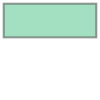

In [33]:
p = Polygon([(-123.16951040099778,49.17010599933944), (-123.20813421081226,49.17010599933944), (-123.20813421081226,49.15607465341073),
             (-123.16951040099778,49.15607465341073)])
p


In [57]:
df = pd.read_csv("gbif_summary.csv", low_memory=False)

In [59]:
df.to_hdf("gbif_summary.hdf", key="gbif")

In [65]:
store = pd.HDFStore('gbif_summary.hdf')

In [62]:
selected_regions = {"municipality":1}

In [66]:
store.select("gbif")

,Unnamed: 0,species,year,decimalLongitude,decimalLatitude,municipality,datasetName
0,0,Bombus impatiens,2018,-123.214155,49.220991,1,iNaturalist Research-grade Observations
1,1,Calidris bairdii,2018,-123.212838,49.221082,1,iNaturalist Research-grade Observations
2,2,Hydroprogne caspia,2018,-123.213369,49.219913,1,iNaturalist Research-grade Observations
3,3,Passerculus sandwichensis,2018,-123.213379,49.220764,1,iNaturalist Research-grade Observations
4,4,Calidris bairdii,2018,-123.213018,49.220716,1,iNaturalist Research-grade Observations
5,5,Leptoglossus occidentalis,2018,-123.136212,49.182089,1,iNaturalist Research-grade Observations
6,6,Pheucticus melanocephalus,2018,-123.195707,49.167614,1,iNaturalist Research-grade Observations
7,7,Sterna paradisaea,2018,-123.255114,49.207328,1,iNaturalist Research-grade Observations
8,8,Eremophila alpestris,2018,-123.227353,49.213365,1,iNaturalist Research-grade Observations
9,9,Lathyrus japonicus,2018,-123.251156,49.208174,1,iNaturalist Research-grade Observations


In [74]:
df = pd.read_csv("gbif_map.csv", low_memory=False)

In [75]:
df.to_pickle("gbif_map.pkl")

In [54]:
df.to_hdf("gbif_summary.hdf", key="df_taxon")

In [48]:
pd.read_pickle("gbif_summary.pkl")

,Unnamed: 0,species,year,decimalLongitude,decimalLatitude,municipality,datasetName
0,0,Bombus impatiens,2018,-123.214155,49.220991,1,iNaturalist Research-grade Observations
1,1,Calidris bairdii,2018,-123.212838,49.221082,1,iNaturalist Research-grade Observations
2,2,Hydroprogne caspia,2018,-123.213369,49.219913,1,iNaturalist Research-grade Observations
3,3,Passerculus sandwichensis,2018,-123.213379,49.220764,1,iNaturalist Research-grade Observations
4,4,Calidris bairdii,2018,-123.213018,49.220716,1,iNaturalist Research-grade Observations
5,5,Leptoglossus occidentalis,2018,-123.136212,49.182089,1,iNaturalist Research-grade Observations
6,6,Pheucticus melanocephalus,2018,-123.195707,49.167614,1,iNaturalist Research-grade Observations
7,7,Sterna paradisaea,2018,-123.255114,49.207328,1,iNaturalist Research-grade Observations
8,8,Eremophila alpestris,2018,-123.227353,49.213365,1,iNaturalist Research-grade Observations
9,9,Lathyrus japonicus,2018,-123.251156,49.208174,1,iNaturalist Research-grade Observations


In [37]:
geometry = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs={'init': 'epsg:4326'})

In [38]:
new_df = geo_df[geo_df.geometry.within(p)]

In [39]:
new_df.shape

(24007, 8)

In [28]:
geo_df.to_file("gbif_summary.shp")

KeyboardInterrupt: 

In [ ]:
geo_df.read_file("gbif_summary.shp")

In [78]:
from shapely.geometry import Point, Polygon

In [80]:
poly = Polygon([[-123.383135, 49.214433], [-123.417157, 49.149649], [-123.237193, 49.176854], [-123.383135, 49.214433]])

In [87]:
geo_df.geometry[0].within(p)

False

In [ ]:
geo_df[geo_df[geometry] in p]

In [98]:
df = pd.read_csv("map_django/biodivmap/gbif_map.csv")

In [100]:
geometry = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]
# fix coordinate system
geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs={'init': 'epsg:4326'})

In [101]:
spatial_index = geo_df.sindex

In [94]:
possible_matches_index = list(spatial_index.intersection(poly.bounds))

In [95]:
possible_matches = geo_df.iloc[possible_matches_index]

In [96]:
precise_matches = possible_matches[possible_matches.intersects(poly)]

In [97]:
precise_matches

,Unnamed: 0,species,year,decimalLongitude,decimalLatitude,municipality,datasetName,geometry
2844432,2844432,Cerorhinca monocerata,2017,-123.393752,49.173039,26,EOD - eBird Observation Dataset,POINT (-123.393752 49.173039)
2843488,2843488,Larus glaucescens,2017,-123.393752,49.173039,26,EOD - eBird Observation Dataset,POINT (-123.393752 49.173039)
2844711,2844711,Larus californicus,2018,-123.399610,49.173494,26,EOD - eBird Observation Dataset,POINT (-123.39961 49.173494)
2846823,2846823,Larus glaucescens,2018,-123.399610,49.173494,26,EOD - eBird Observation Dataset,POINT (-123.39961 49.173494)
2841122,2841122,Larus glaucescens,2016,-123.384084,49.188669,26,EOD - eBird Observation Dataset,POINT (-123.384084 49.188669)
2841123,2841123,Larus californicus,2016,-123.384084,49.188669,26,EOD - eBird Observation Dataset,POINT (-123.384084 49.188669)
2843489,2843489,Larus glaucescens,2017,-123.374546,49.190449,26,EOD - eBird Observation Dataset,POINT (-123.374546 49.190449)
2833620,2833620,Uria aalge,2017,-123.328344,49.196713,26,EOD - eBird Observation Dataset,POINT (-123.328344 49.196713)
2833619,2833619,Larus glaucescens,2017,-123.328344,49.196713,26,EOD - eBird Observation Dataset,POINT (-123.328344 49.196713)
2833618,2833618,Larus canus,2017,-123.328344,49.196713,26,EOD - eBird Observation Dataset,POINT (-123.328344 49.196713)


In [104]:
gpd.GeoDataFrame(columns=precise_matches.columns)

,Unnamed: 0,species,year,decimalLongitude,decimalLatitude,municipality,datasetName,geometry


In [ ]:
gpd.